In [1]:
import numpy as np
import pandas as pd
import mne
import glob
import os
from scipy.signal import resample
from matplotlib import pyplot as plt
from idun_sdk import do_bandpass, prepare_fft
from data_labeler import calculate_bad_epochs
from scipy.signal import find_peaks
import copy

In [2]:
def calculate_lag(signal_1, signal_2):
    '''
    This function calculates the lag between two signals.
    :param signal_1: first signal
    :param signal_2: second signal
    '''
    # check if there is nan in the signals
    if np.isnan(signal_1).any() or np.isnan(signal_2).any():
        # create a nan array with the same length as the signals
        nan_array = np.empty(len(signal_1))
        nan_array[:] = np.nan
        return nan_array, np.nan
    correlation = np.correlate(signal_1, signal_2, mode="full")
    max_correlation = np.max(correlation)
    index_of_max_corr = np.argmax(correlation)
    num_samples = len(signal_1)
    lag = index_of_max_corr - (num_samples - 1)
    return correlation, max_correlation, lag

def epoch_data(data, samples_per_epoch):
    """Split the data into epochs."""
    num_epochs = len(data) // samples_per_epoch
    # remove the last epoch if it is not complete
    data = data[:num_epochs * samples_per_epoch]
    return np.array_split(data, num_epochs)

def remove_outliers(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 -  IQR
    upper_bound = Q3 + IQR
    return data[(data >= lower_bound) & (data <= upper_bound)]

### Variables

In [3]:
FILTER_RANGE = [20,40]
BASE_SAMPLE_RATE = 250

### Upload data

In [4]:
edf_file_path = glob.glob(os.path.join("data", '*.edf'))[0]
csv_file_path = glob.glob(os.path.join("data", '*.csv'))[0]

prodigy_raw_data = mne.io.read_raw_edf(edf_file_path, preload=True)

# upload csv file using numpy
idun_raw_data = np.genfromtxt(csv_file_path, delimiter=',', skip_header=1)

### Unpack prodigy

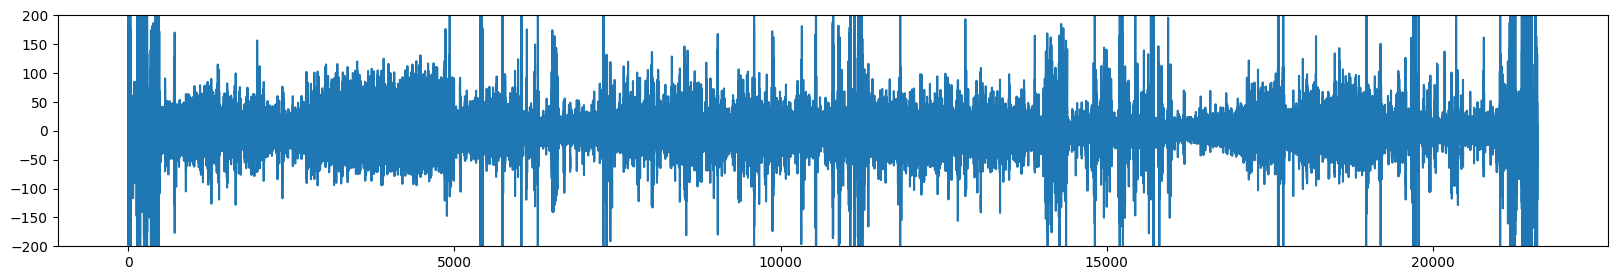

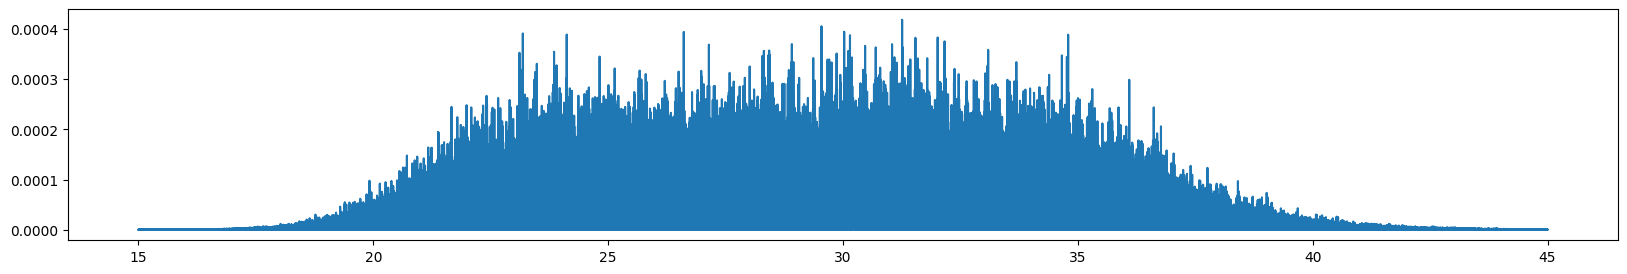

In [5]:
CHANNEL_1 = "LEFT_EYE"
CHANNEL_2 = "RIGHT_EYE"
PRODIGY_SAMPLE_RATE = 120
prodigy_data, prodigy_times = prodigy_raw_data[:, :]
prodigy_channel_names = prodigy_raw_data.ch_names

# find the position of the channels in channel_names
channel_1_index = prodigy_channel_names.index(CHANNEL_1)
channel_2_index = prodigy_channel_names.index(CHANNEL_2)
# extract the data from the channels
prodigy_channel_1_data = prodigy_data[channel_1_index, :]
prodigy_channel_2_data = prodigy_data[channel_2_index, :]
# minus right eye from left eye
prodigy_channel_1_minus_2 = prodigy_channel_1_data - prodigy_channel_2_data
prodigy_channel_1_minus_2 = prodigy_channel_1_minus_2*1000000

# Upsample to 250 Hz
num_samples_250 = int(BASE_SAMPLE_RATE/PRODIGY_SAMPLE_RATE*len(prodigy_channel_1_minus_2))
resampled_prodigy_data = resample(prodigy_channel_1_minus_2, num_samples_250)

# Filter
prodigy_filtered_data_rs = do_bandpass(resampled_prodigy_data,  [FILTER_RANGE[0], FILTER_RANGE[1]], BASE_SAMPLE_RATE)
resampled_times = np.linspace(0, len(prodigy_filtered_data_rs)/BASE_SAMPLE_RATE, len(prodigy_filtered_data_rs))


plt.figure(figsize=(20, 3))
plt.plot(resampled_times, resampled_prodigy_data)
plt.ylim(-200, 200)

pr_freqs_rs, pr_fft_rs = prepare_fft(prodigy_filtered_data_rs, FILTER_RANGE[0]-5 ,FILTER_RANGE[1]+5, BASE_SAMPLE_RATE)
plt.figure(figsize=(20, 3))
plt.plot(pr_freqs_rs, pr_fft_rs)


### Unpack IDUN

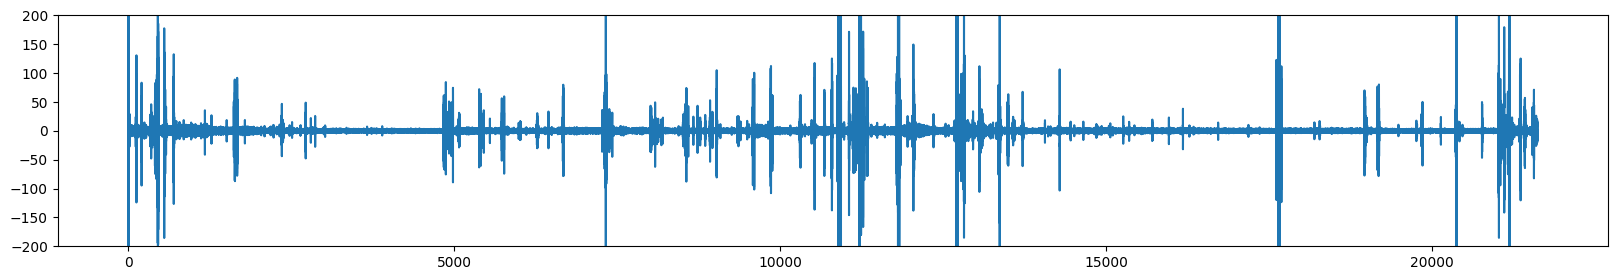

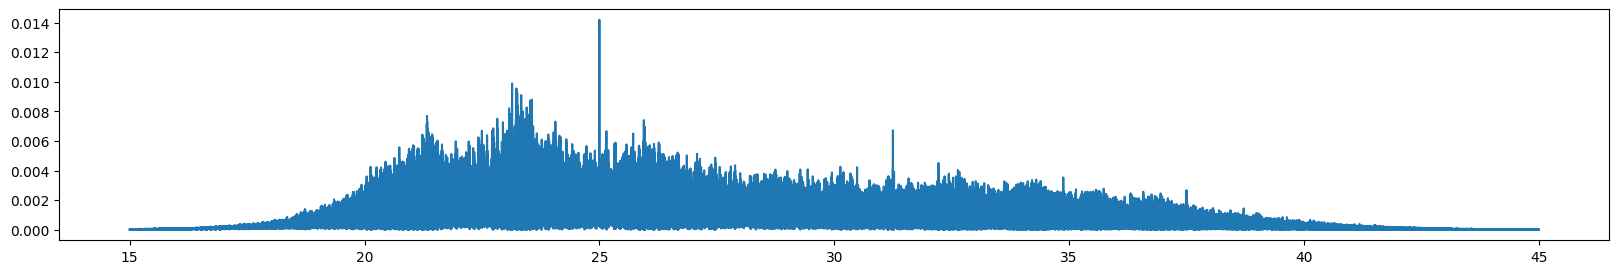

In [6]:
IDUN_SAMPLE_RATE = 250
idun_data = idun_raw_data[:,1]
idun_time_stamps = idun_raw_data[:,0]
idun_time_stamps = idun_time_stamps - idun_time_stamps[0]

# bandpass filter
idun_filtered_data = do_bandpass(idun_data, [FILTER_RANGE[0], FILTER_RANGE[1]], IDUN_SAMPLE_RATE)
plt.figure(figsize=(20, 3))
plt.plot(idun_time_stamps, idun_filtered_data)
plt.ylim(-200, 200)

id_freqs, id_fft = prepare_fft(idun_filtered_data, FILTER_RANGE[0]-5 ,FILTER_RANGE[1]+5 ,IDUN_SAMPLE_RATE)
plt.figure(figsize=(20, 3))
plt.plot(id_freqs, id_fft)

### Clean data

In [7]:
# prodigy_labels, prodigy_epoch_freq_powers = calculate_bad_epochs(prodigy_filtered_data_rs, sfreq = BASE_SAMPLE_RATE, outlier_threshold = 6, epoch_length = BASE_SAMPLE_RATE)
# prodigy_cleaned_data = np.where(prodigy_labels == 1, np.nan, prodigy_filtered_data_rs)
prodigy_cleaned_data = prodigy_filtered_data_rs
# idun_labels, idun_epoch_freq_powers = calculate_bad_epochs(idun_filtered_data, sfreq = BASE_SAMPLE_RATE, outlier_threshold = 6, epoch_length = BASE_SAMPLE_RATE)
# idun_cleaned_data = np.where(idun_labels == 1, np.nan, idun_filtered_data)
idun_cleaned_data = idun_filtered_data

# Find which one is longer and how much longer
if len(prodigy_cleaned_data) > len(idun_cleaned_data):
    longer_len = len(prodigy_cleaned_data)
    shorter_len = len(idun_cleaned_data)
    diff = int(longer_len - shorter_len)
    prodigy_cleaned_data = prodigy_cleaned_data[int(diff/2):int(-diff/2)]
else:
    longer_len = len(idun_cleaned_data)
    shorter_len = len(prodigy_cleaned_data)
    diff = int(longer_len - shorter_len)
    idun_cleaned_data = idun_cleaned_data[int(diff/2):int(-diff/2)]
    
same_times = np.linspace(0, len(idun_cleaned_data)/BASE_SAMPLE_RATE, len(idun_cleaned_data))


5400000
5400000


(-200.0, 200.0)

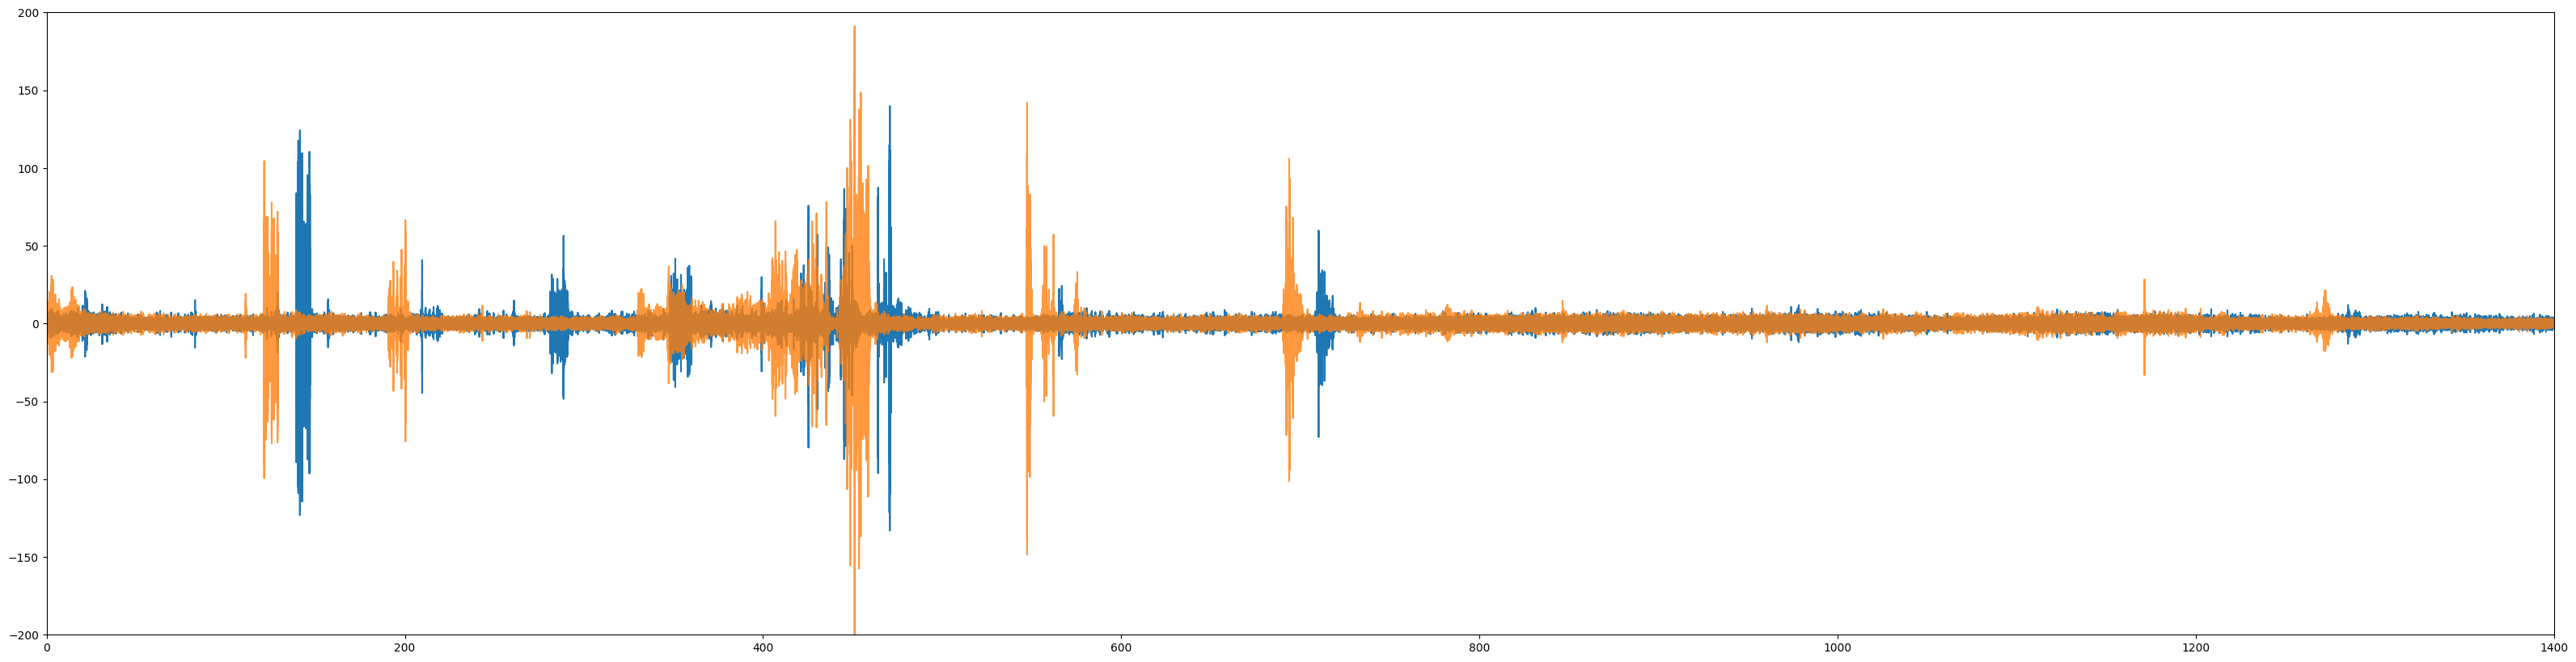

In [8]:
plt.figure(figsize=(40, 10))
# make 0s 1s and 1s 0s in prodigy_labels
plt.plot(same_times, prodigy_cleaned_data)
plt.ylim(-200, 200)
print(len(prodigy_cleaned_data))
# make 0s 1s and 1s 0s in prodigy_labels
plt.plot(same_times, 0.8*idun_cleaned_data, alpha = 0.8)
print(len(idun_cleaned_data))
plt.xlim(0, 1400)
plt.ylim(-200, 200)

### Calculate lag

In [9]:
samples_per_epoch = BASE_SAMPLE_RATE * 60
prodigy_epochs = epoch_data(prodigy_cleaned_data, samples_per_epoch)
idun_epochs = epoch_data(idun_cleaned_data, samples_per_epoch)

### Notes
1. Initial sync should be done manually
2. Epochs should be smaller
3. Use also intensit of correlations
4. Normalise the signal

In [10]:
correlation_arr = []
lag_arr = []
max_corr_arr = []
for idx, epoch in enumerate(prodigy_epochs):
    
    corr, max_corr, lag = calculate_lag(epoch, idun_epochs[idx])
    max_corr_arr.append(max_corr)
    # chekck that lag is not nan
    # fig, ax = plt.subplots(1, 1, figsize=(12, 4))
    # create seconds plot based on length of epoch and sampling rate
    seconds = np.arange(0, len(epoch)/BASE_SAMPLE_RATE, 1/BASE_SAMPLE_RATE)
    # plt.plot(seconds,epoch, label="prodigy")
    # plt.plot(seconds,0.8*idun_epochs[idx], label="idun")
    # count the number of digits in the max correlation
    num_digits = len(str(int(max_corr)))
    # plt.title(f"Lag: {lag/250}, Correlation: {num_digits}")
    correlation_arr.append(corr)
    lag_arr.append(lag)


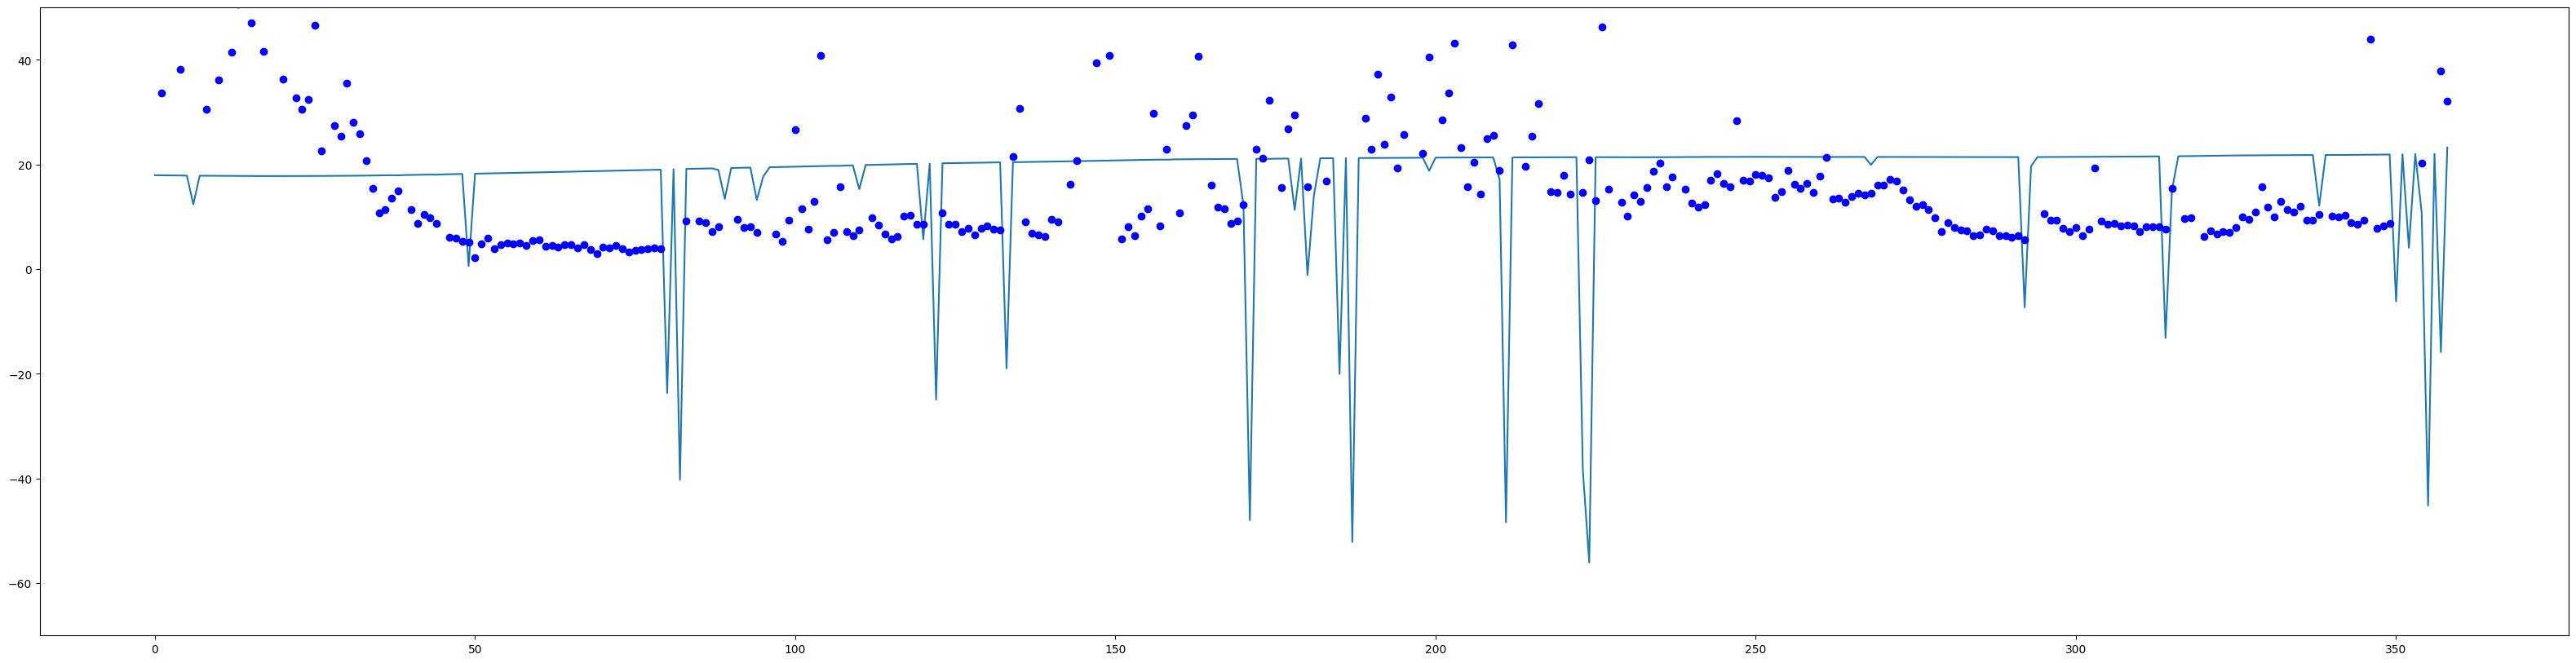

In [11]:
lag_arr_copy = lag_arr[1:].copy()

# Assuming the above code, we just continue:
plt.figure(figsize=(40, 10))
plt.plot(np.array(lag_arr_copy)/250)
plt.plot(np.array(max_corr_arr)/len(lag_arr_copy), 'bo')
plt.ylim(-70,50)
plt.show()

### adjust based on first analysis

(-100.0, 100.0)

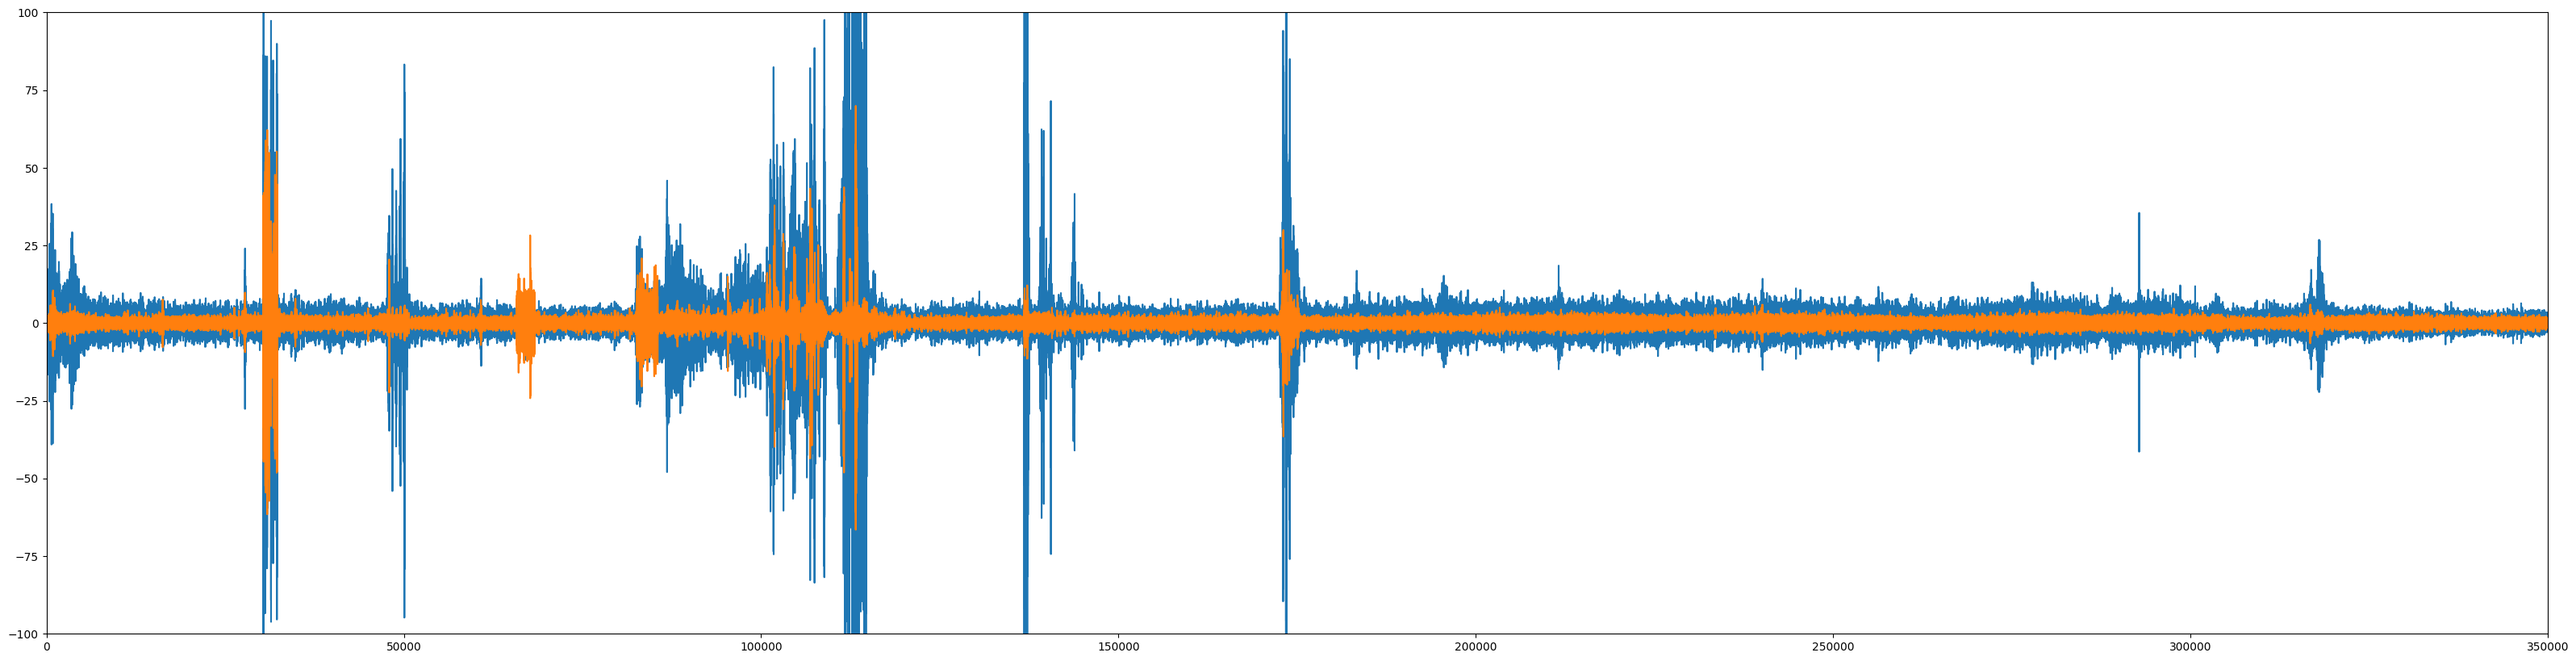

In [12]:
lag_arr = np.array(lag_arr)
lag_initial = lag_arr[:20]
lag_initial = remove_outliers(lag_initial)
lag_mean = int(np.mean(lag_initial))

# cut the lag_mean data from the start of idun_cleaned_data if it is positive or from the start of prodigy_cleaned_data if negative
if lag_mean < 0:
    idun_cut_data = idun_cleaned_data[lag_mean:]
    prodigy_cut_data = prodigy_cleaned_data[:-(lag_mean)]
else:
    idun_cut_data = idun_cleaned_data[:-(lag_mean)]
    prodigy_cut_data = prodigy_cleaned_data[lag_mean:]

# plot the data
plt.figure(figsize=(40, 10))
plt.plot(idun_cut_data, label='idun')
plt.plot(0.5*prodigy_cut_data, label='prodigy')
plt.xlim(0, 1400*BASE_SAMPLE_RATE)
plt.ylim(-100,100)

### Do a more fine grained sync

In [76]:
samples_per_epoch = BASE_SAMPLE_RATE * 30 # 30 works best
cutted_prodigy_epochs = epoch_data(prodigy_cut_data, samples_per_epoch)
cutted_idun_epochs = epoch_data(idun_cut_data, samples_per_epoch)

In [77]:
fine_correlation_arr = []
fine_lag_arr = []
fine_max_corr_arr = []
for idx, epoch in enumerate(cutted_prodigy_epochs):
    
    corr, max_corr, lag = calculate_lag(epoch, cutted_idun_epochs[idx])
    fine_max_corr_arr.append(max_corr)
    # chekck that lag is not nan
    # fig, ax = plt.subplots(1, 1, figsize=(12, 4))
    # create seconds plot based on length of epoch and sampling rate
    seconds = np.arange(0, len(epoch)/BASE_SAMPLE_RATE, 1/BASE_SAMPLE_RATE)
    # plt.plot(seconds,epoch, label="prodigy")
    # plt.plot(seconds,0.8*idun_epochs[idx], label="idun")
    # count the number of digits in the max correlation
    num_digits = len(str(int(max_corr)))
    # plt.title(f"Lag: {lag/250}, Correlation: {num_digits}")
    fine_correlation_arr.append(corr)
    fine_lag_arr.append(lag)

(-1.0, 5.0)

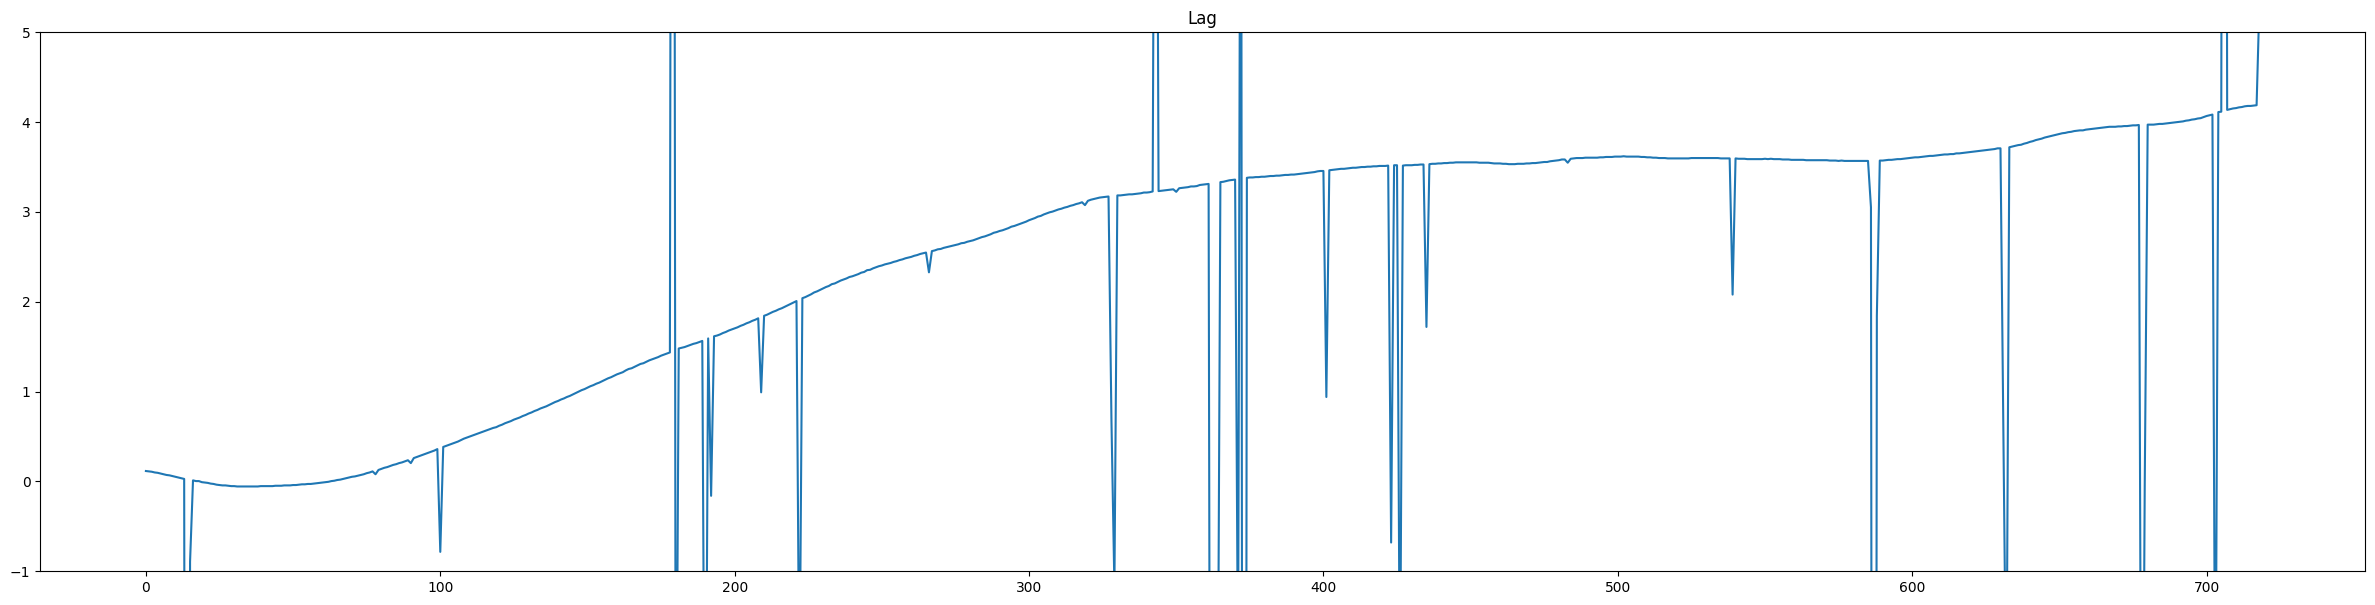

In [79]:
fine_lag_arr_copy = fine_lag_arr.copy()
# Assuming the above code, we just continue:
plt.figure(figsize=(30, 7))
plt.plot(np.array(fine_lag_arr_copy)/250)
plt.title('Lag')
plt.ylim(-1,5)

### Do some cleaning

In [80]:
def replace_outliers(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1  - 0.5*IQR
    upper_bound = Q3 + 0.5*IQR
    # Use np.where to replace outliers with np.nan
    cleaned_data = np.where((data < lower_bound) | (data > upper_bound), np.nan, data)
    return cleaned_data

719

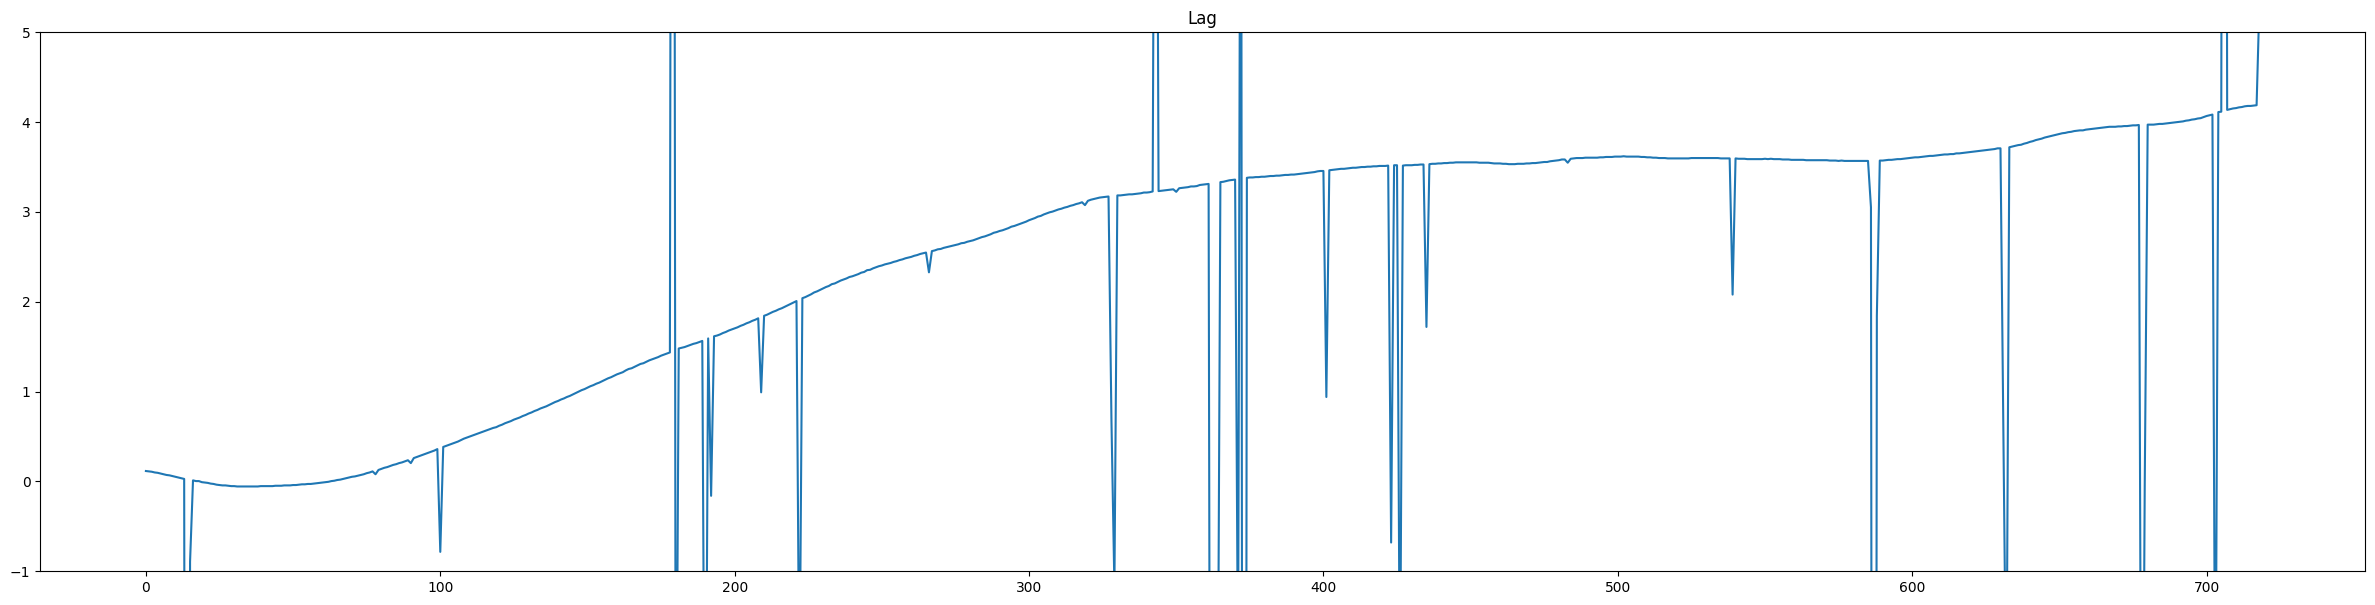

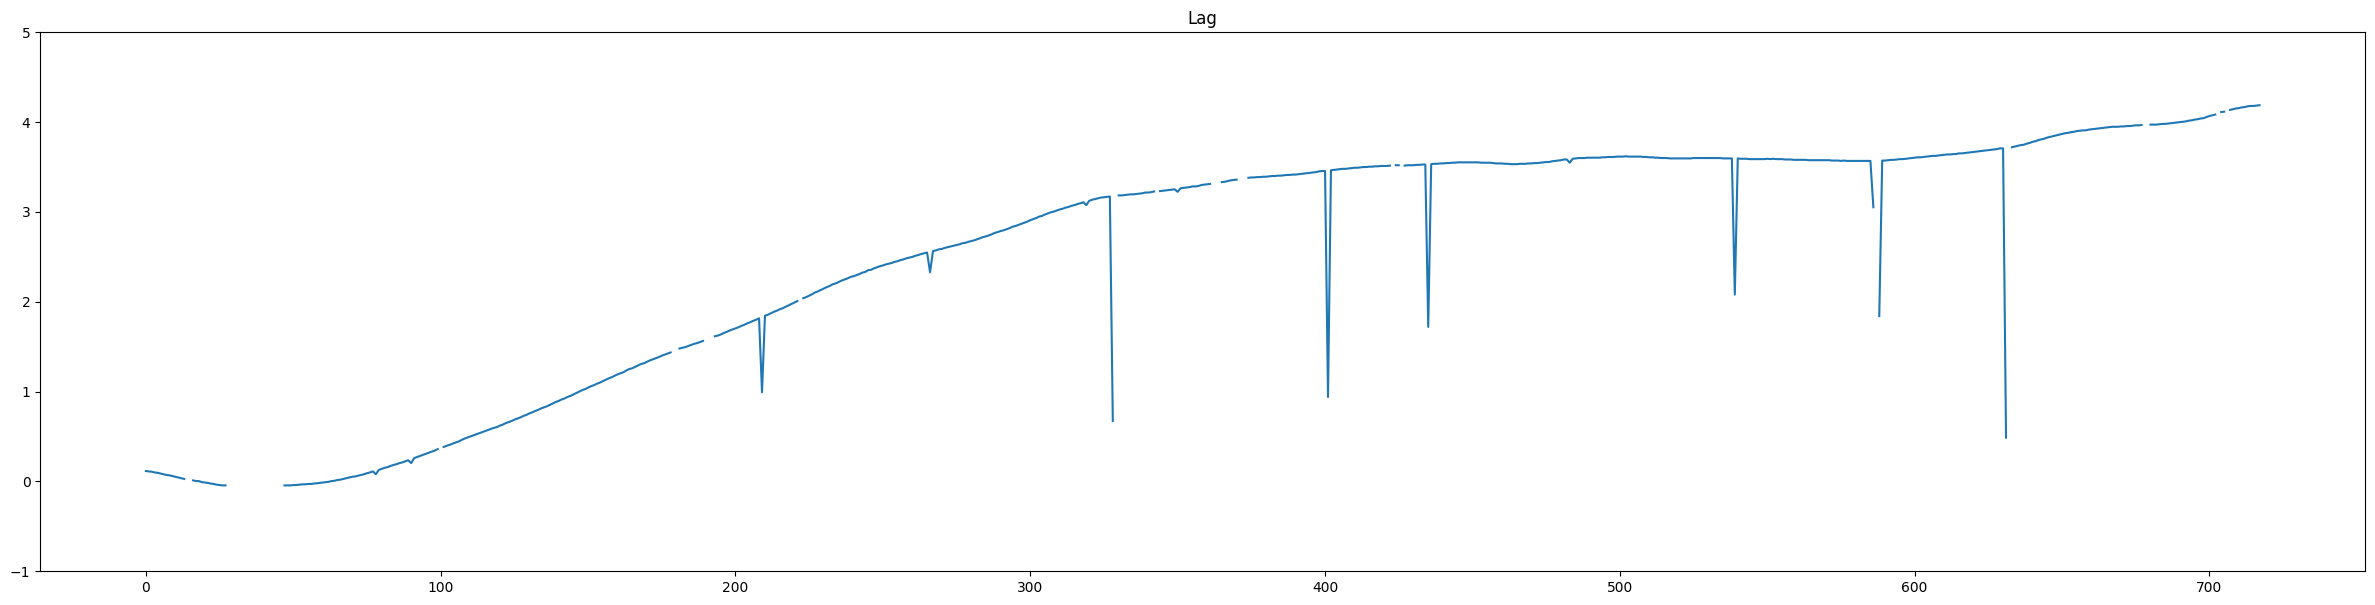

In [81]:
cleaned_fine_lag_arr = replace_outliers(fine_lag_arr_copy)
# Assuming the above code, we just continue:
plt.figure(figsize=(30, 7))
#plt.plot(np.array(fine_lag_arr_copy)/250)
plt.plot(np.array(fine_lag_arr_copy)/250)
plt.title('Lag')
plt.ylim(-1,5)

plt.figure(figsize=(30, 7))
#plt.plot(np.array(fine_lag_arr_copy)/250)
plt.plot(np.array(cleaned_fine_lag_arr)/250)
plt.title('Lag')
plt.ylim(-1,5)
len(cleaned_fine_lag_arr)


675 675
0.10268855291511454
4.240692944320308
[ 0.00000000e+00 -2.41860393e+00  4.21024770e-02 -1.26522462e-04
  1.46915474e-07 -5.84163033e-11] 25.672138228778635


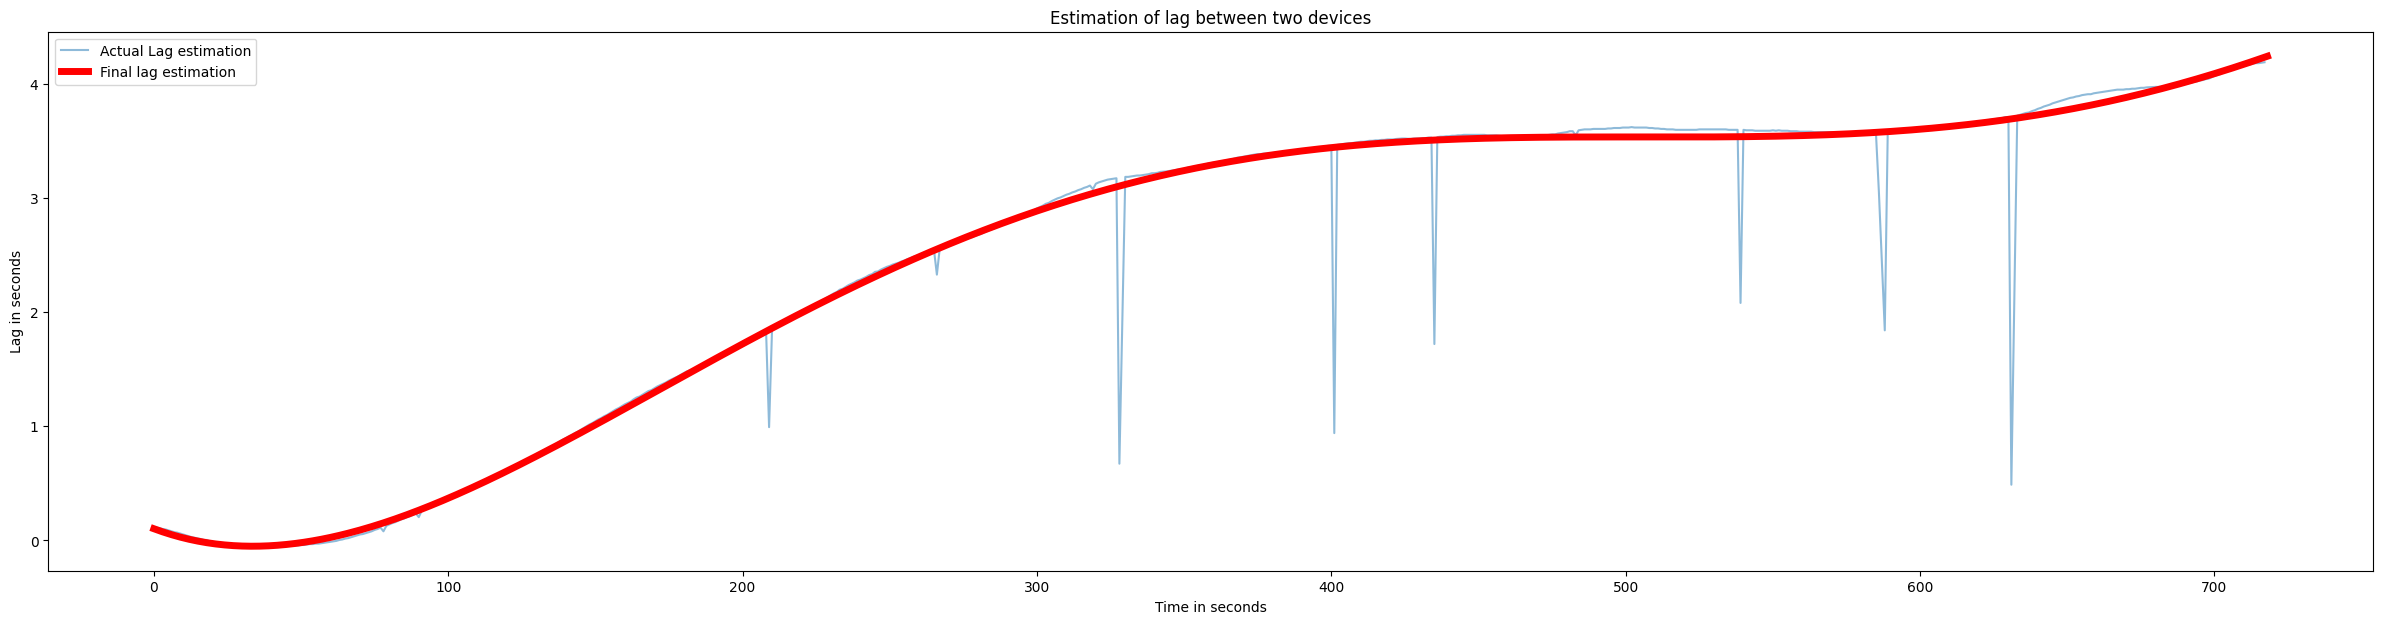

In [83]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

y = cleaned_fine_lag_arr
X = np.arange(len(y)).reshape(-1, 1)
X_copy = X.copy()
# find where y is not nan
not_nan_idx = np.where(~np.isnan(y))[0]
y = y[not_nan_idx]
X = X[not_nan_idx]
print(len(y), len(X))

# Transform the features to 2nd degree polynomial features
poly = PolynomialFeatures(degree=5)
X_poly = poly.fit_transform(X)
# Create a LinearRegression model and fit it to the polynomial features
reg = LinearRegression().fit(X_poly, y)
# Predict values
X_new_poly = poly.transform(X_copy)
y_pred = reg.predict(X_new_poly)

# print the first value of y_pred
print(y_pred[0]/250)
# print the last value of y_pred
print(y_pred[-1]/250)
# print the gradient and shift
print(reg.coef_, reg.intercept_)

# Plotting the regression curve
plt.figure(figsize=(30, 7))
plt.plot(X, y/250, label='Actual Lag estimation', alpha=0.5)
plt.plot(X_copy, y_pred/250, "r-", label="Final lag estimation", linewidth=5)
plt.title("Estimation of lag between two devices")
plt.xlabel("Time in seconds")
plt.ylabel("Lag in seconds")
plt.legend()
plt.show()
